In [1]:
%matplotlib inline
from importlib import reload
import utils; reload(utils)
from utils import *

In [2]:
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.utils import shuffle
import time

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2
from imgaug import augmenters as iaa


########################################################################################################################
######                                        Plot utility functions                                              ######
########################################################################################################################

 
def plot_results(metrics, axis, lbs, xlb, ylb,  title, fig_size=(7, 5), epochs_interval=10):
    """
    Nifty utility function to plot results of the execution of our model
    """
    fig, ax = plt.subplots(figsize=fig_size)
    
    total_epochs = metrics[0].shape[0]
    x_values = np.linspace(1, total_epochs, num=total_epochs, dtype=np.int32)
    
    for m, l in zip(metrics, lbs):
        ax.plot(line1 = ax.plot(x_values, m[:, axis], linewidth=2, label=l))
    
    ax.set(xlabel=xlb, ylabel=ylb, title=title)
    ax.xaxis.set_ticks(np.linspace(1, total_epochs, num=int(total_epochs/epochs_interval), dtype=np.int32))
    ax.legend(loc='lower right')
    plt.show()
    
def plot_model_results(metrics, axes, lbs, xlb, ylb, titles, fig_title, fig_size=(7, 5), epochs_interval=10):
    """
    Nifty utility function to plot results of the execution of our model
    """
    fig, axs = plt.subplots(nrows=1, ncols=len(axes), figsize=fig_size)
    print("Length of axis: {0}".format(axs.shape))
    
    total_epochs = metrics[0].shape[0]
    x_values = np.linspace(1, total_epochs, num=total_epochs, dtype=np.int32)
    
    for m, l in zip(metrics, lbs):
        for i in range(0, len(axes)):
            ax = axs[i]
            axis = axes[i]
            ax.plot(x_values, m[:, axis], linewidth=2, label=l)
            ax.set(xlabel=xlb[i], ylabel=ylb[i], title=titles[i])
            ax.xaxis.set_ticks(np.linspace(1, total_epochs, num=int(total_epochs/epochs_interval), dtype=np.int32))
            ax.legend(loc='center right')
    
    plt.suptitle(fig_title, fontsize=14, fontweight='bold')
    plt.show()
    
  

def show_image_list(img_list, img_labels, title, cols=2, fig_size=(15, 15), show_ticks=True):
    """
    Utility function to show us a list of traffic sign images
    """
    img_count = len(img_list)
    rows = img_count // cols
    cmap = None

    fig, axes = plt.subplots(rows, cols, figsize=fig_size)
    
    for i in range(0, img_count):
        img_name = img_labels[i]     
        img = img_list[i]
        if len(img.shape) < 3 or img.shape[-1] < 3:
            cmap = "gray"
            img = np.reshape(img, (img.shape[0], img.shape[1]))
        
        if not show_ticks:            
            axes[i].axis("off")
            
        axes[i].imshow(img, cmap=cmap)
    
    fig.suptitle(title, fontsize=12, fontweight='bold', y = 0.6)
    fig.tight_layout()
    plt.show()
    
    return


def show_random_dataset_images(group_label, imgs, to_show=5):
    """
    This function takes a DataFrame of items group by labels as well as a set of images and randomly selects to_show images to display
    """
    for (lid, lbl), group in group_label:
        #print("[{0}] : {1}".format(lid, lbl))    
        rand_idx = np.random.randint(0, high=group['img_id'].size, size=to_show, dtype='int')
        selected_rows = group.iloc[rand_idx]

        selected_img = list(map(lambda img_id: imgs[img_id], selected_rows['img_id']))
        selected_labels = list(map(lambda label_id: label_id, selected_rows['label_id']))
        show_image_list(selected_img, selected_labels, "{0}: {1}".format(lid, lbl), cols=to_show, fig_size=(7, 7), show_ticks=False)
    
    
########################################################################################################################
######                                        Data manipulation functions                                         ######
########################################################################################################################
    
    
def group_img_id_to_lbl(lbs_ids, lbs_names):    
    """
    Utility function to group images by label 
    """
    arr_map = []
    for i in range(0, lbs_ids.shape[0]):
        label_id = lbs_ids[i]
        label_name = lbs_names[lbs_names["ClassId"] == label_id]["SignName"].values[0]
        arr_map.append({"img_id": i, "label_id": label_id, "label_name": label_name})
    
    return pd.DataFrame(arr_map)


def group_img_id_to_lb_count(img_id_to_lb):
    """
    Returns a pivot table table indexed by label id and label name, where the aggregate function is count
    """
    return pd.pivot_table(img_id_to_lb,index=["label_id","label_name"],values=["img_id"], aggfunc='count')


        

def create_sample_set(grouped_imgs_by_label, imgs, labels, pct=0.4):
    """
    Creates a sample set containing pct elements of the original grouped dataset
    """
    X_sample = []
    y_sample = []

    for (lid, lbl), group in grouped_imgs_by_label:
        group_size = group['img_id'].size
        img_count_to_copy = int(group_size * pct)
        rand_idx = np.random.randint(0, high=group_size, size=img_count_to_copy, dtype='int')

        selected_img_ids = group.iloc[rand_idx]['img_id'].values
        selected_imgs = imgs[selected_img_ids]
        selected_labels = labels[selected_img_ids]
        X_sample = selected_imgs if len(X_sample) == 0 else np.concatenate((selected_imgs, X_sample), axis=0)
        y_sample = selected_labels if len(y_sample) == 0 else np.concatenate((selected_labels, y_sample), axis=0)


    return (X_sample, y_sample)

########################################################################################################################
######                                        Image processing functions                                          ######
########################################################################################################################


def normalise_images(imgs, dist):
    """
    Nornalise the supplied images from data in dist
    """
    std = np.std(dist)
    #std = 128
    mean = np.mean(dist)
    #mean = 128
    return (imgs - mean) / std



def to_grayscale(img):
    """
    Converts an image in RGB format to grayscale
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def augment_imgs(imgs, p):
    """
    Performs a set of augmentations with with a probability p
    """
    augs =  iaa.SomeOf((1, 2),
          [
              iaa.Crop(px=(0, 4)), # crop images from each side by 0 to 4px (randomly chosen)
              iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),
              iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
              iaa.Affine(rotate=(-45, 45)), # rotate by -45 to +45 degrees)
              iaa.Affine(shear=(-10, 10)) # shear by -10 to +10 degrees
          ])

    
    seq = iaa.Sequential([iaa.Sometimes(p, augs)])
    
    return seq.augment_images(imgs)

def augment_imgs_until_n(imgs, n, p):
    """
    Takes care of augmenting images with a probability p, until n augmentations have been created
    """

    i = 0
    aug_imgs = []
    while i < n:
        augs = augment_imgs(imgs, p)
        i += len(augs)
        aug_imgs = augs if len(aug_imgs) == 0 else np.concatenate((aug_imgs, augs))
    
    return aug_imgs[0 : n]

In [3]:
user = os.environ["HOME"]

# identify dataset filepaths
datasets_path = user + "/Downloads/traffic-signs-data/"
models_path = user+"/Documents/Stage 4/Stage 4 Project/CarND-Traffic-Sign-Classifier-Project/models/"

# declare training, test and validation files
training_file = datasets_path + "train.p"
validation_file = datasets_path + "valid.p"
testing_file = datasets_path + "test.p"

# pickle the data to increase randomness
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# separate data into features and labels
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], valid['labels']

In [4]:
print("Features shape:", X_train.shape)
print("Labels shape", y_train.shape)

Features shape: (34799, 32, 32, 3)
Labels shape (34799,)


In [8]:
# define numerical variables
# number of training examples
n_train = X_train.shape[0]

# number of validation examples
n_valid = X_valid.shape[0]

# number of test examples
n_test = X_test.shape[0]

# shape of traffic sign image
image_shape = X_train.shape[1:]

# number of unique classes/labels within the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [9]:
# import csv file using pandas
sign_names = pd.read_csv(user+"/CarND-Traffic-Sign-Classifier-Project/signnames.csv")

# display head
sign_names.head(n=3)

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)


In [10]:
# group images in the training set
X_train_id_to_label = group_img_id_to_lbl(y_train, sign_names)

X_train_id_to_label.head(n=3)

,img_id,label_id,label_name
0,0,41,End of no passing
1,1,41,End of no passing
2,2,41,End of no passing


In [11]:
# group by label id to better understand distribution
X_train_group_by_label_count = group_img_id_to_lb_count(X_train_id_to_label)

X_train_group_by_label_count.head(n=5)

,,img_id
label_id,label_name,
0,Speed limit (20km/h),180
1,Speed limit (30km/h),1980
2,Speed limit (50km/h),2010
3,Speed limit (60km/h),1260
4,Speed limit (70km/h),1770


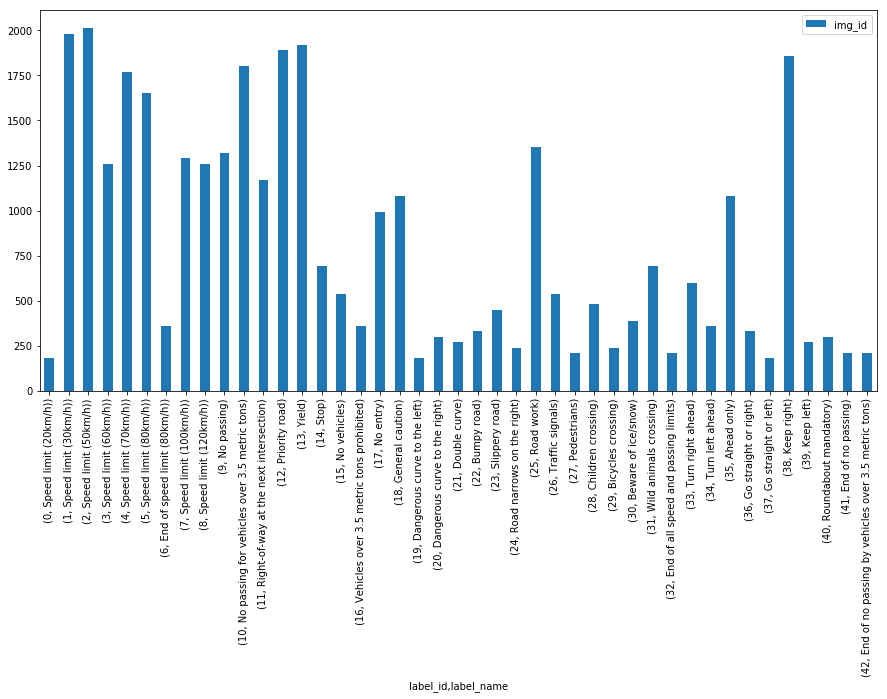

In [12]:
# training set visualisation to see distributoin of datasets
X_train_group_by_label_count.plot(kind='bar', figsize=(15,7))

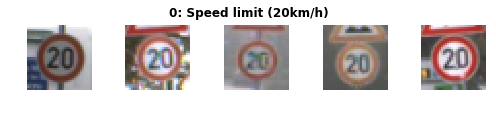

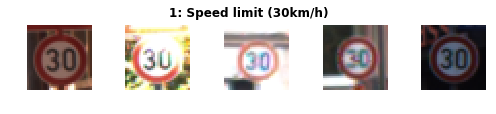

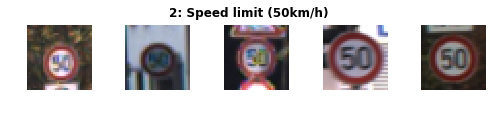

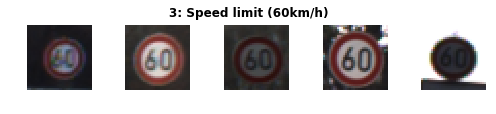

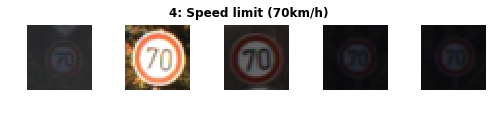

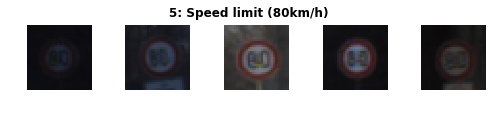

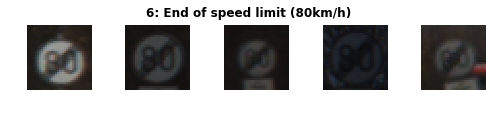

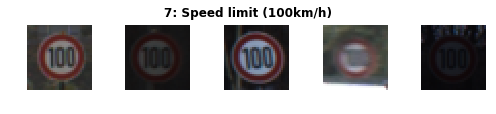

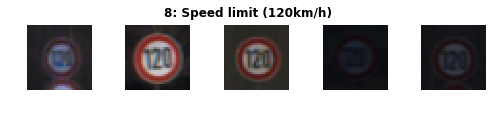

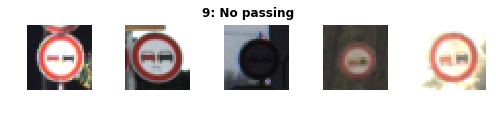

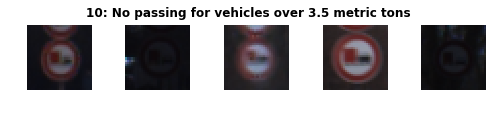

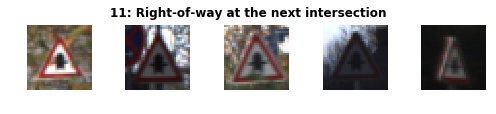

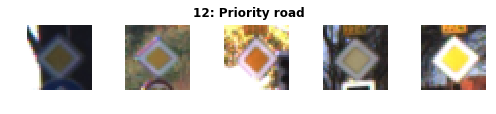

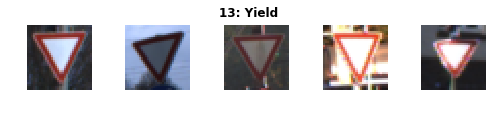

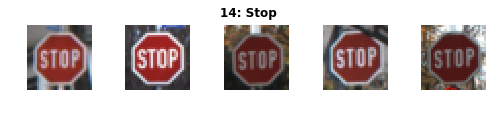

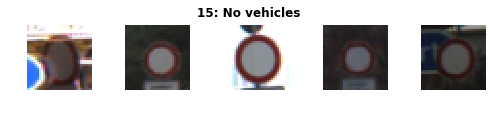

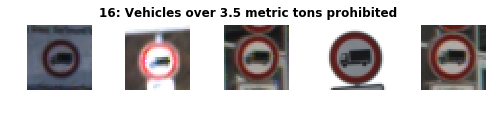

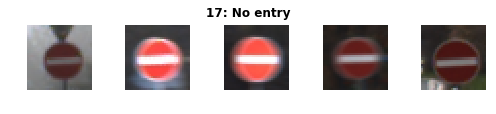

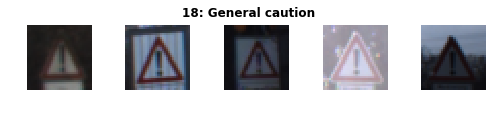

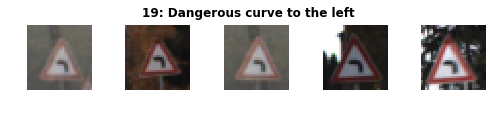

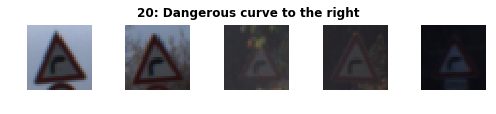

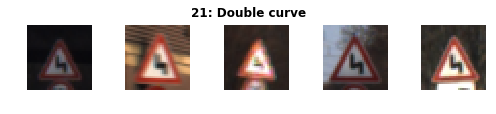

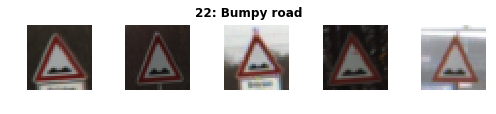

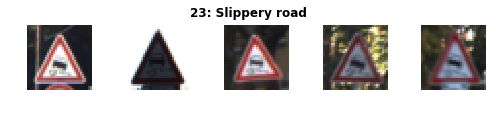

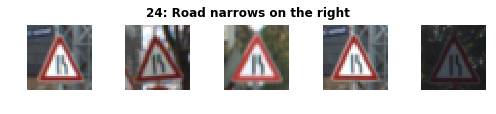

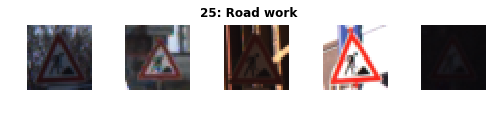

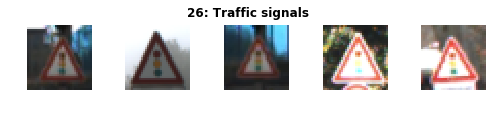

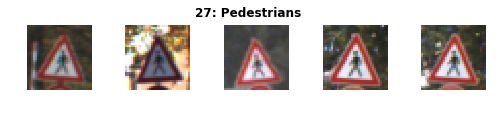

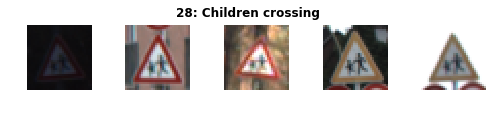

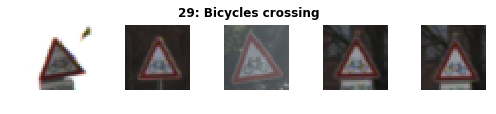

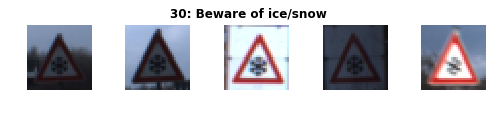

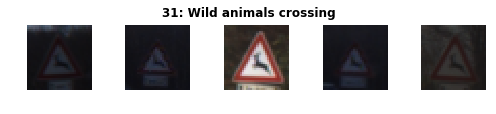

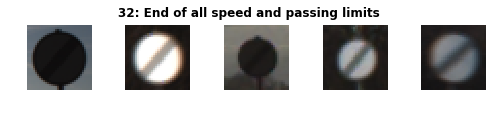

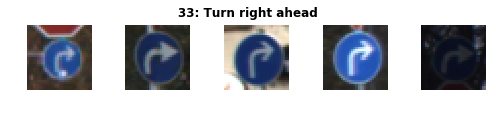

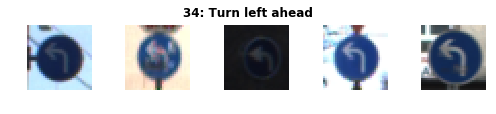

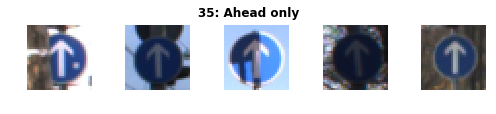

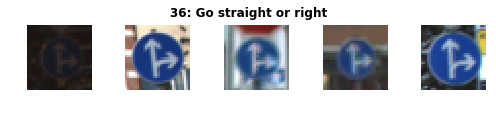

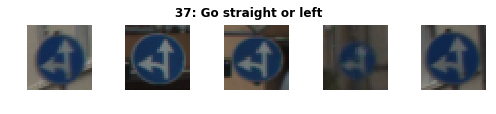

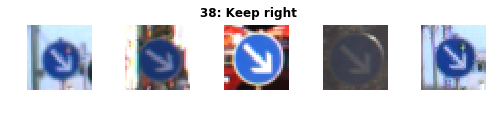

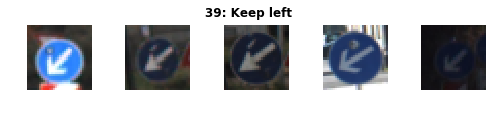

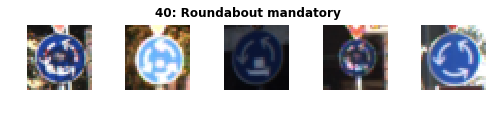

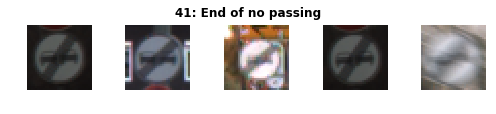

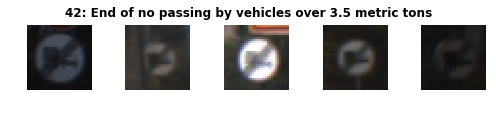

In [13]:
# plot random images from each class to ensure correct grouping
X_train_group_by_label = X_train_id_to_label.groupby(["label_id", "label_name"])
img_per_class = 5

show_random_dataset_images(X_train_group_by_label, X_train)

In [14]:
# Create data frame where images are indexed by id with label for validation
X_valid_id_to_label = group_img_id_to_lbl(y_valid, sign_names)

X_valid_id_to_label.head(n=3)

,img_id,label_id,label_name
0,0,41,End of no passing
1,1,41,End of no passing
2,2,41,End of no passing


In [15]:
# group by label id
X_valid_group_by_label_count = group_img_id_to_lb_count(X_valid_id_to_label)

X_valid_group_by_label_count.head(n=3)

,,img_id
label_id,label_name,
0,Speed limit (20km/h),30
1,Speed limit (30km/h),240
2,Speed limit (50km/h),240


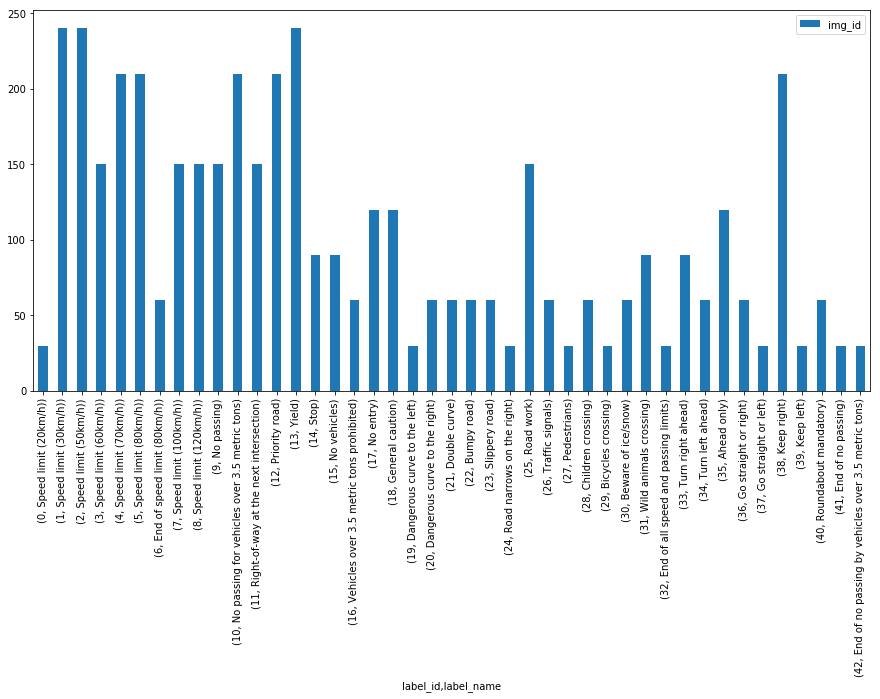

In [16]:
# training set visualisation to see distributoin of validation datasets
X_valid_group_by_label_count.plot(kind='bar', figsize=(15, 7))

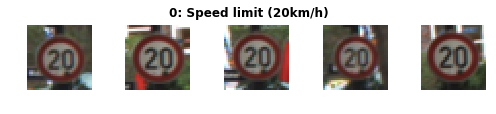

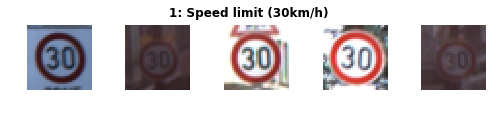

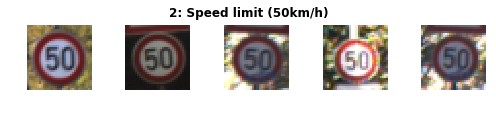

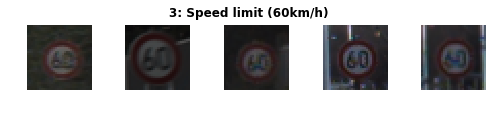

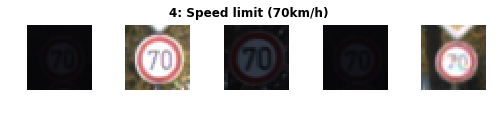

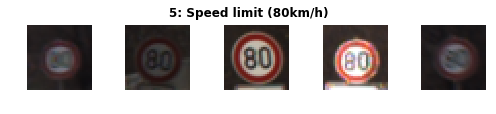

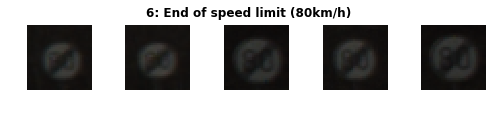

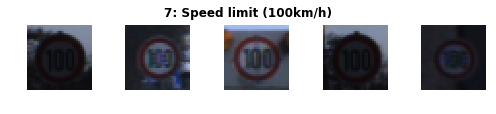

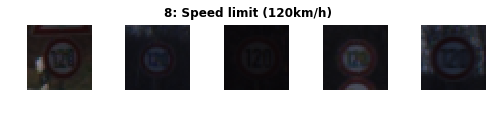

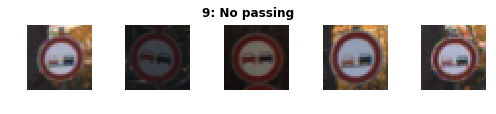

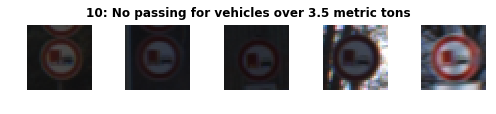

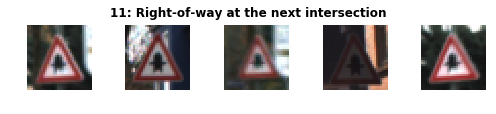

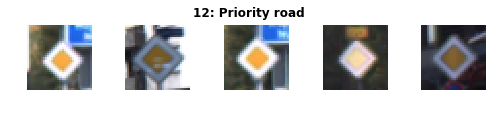

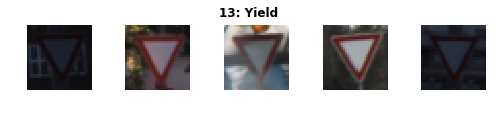

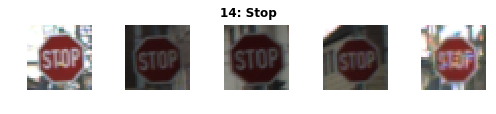

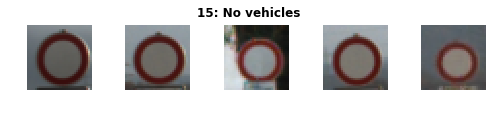

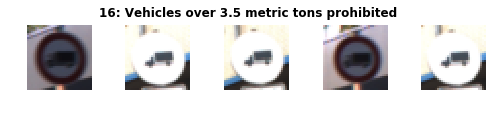

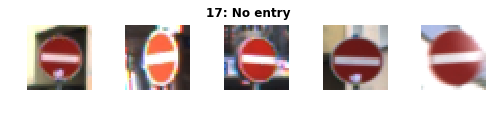

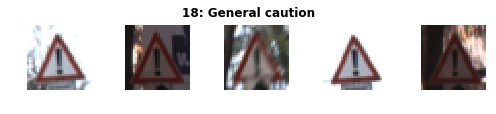

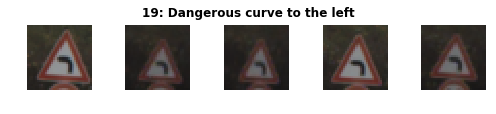

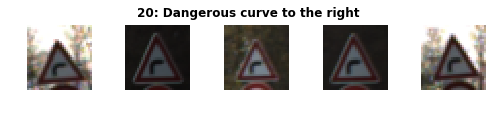

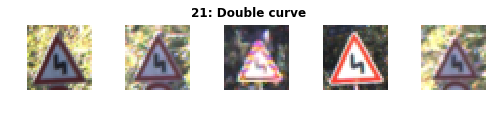

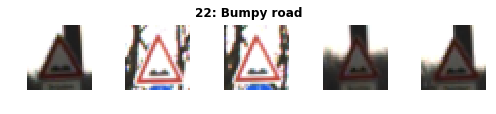

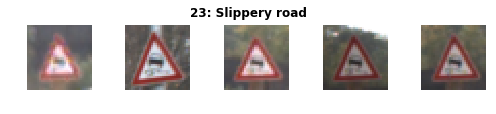

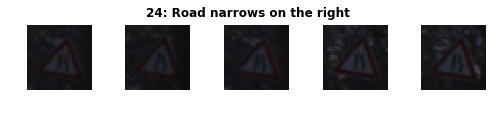

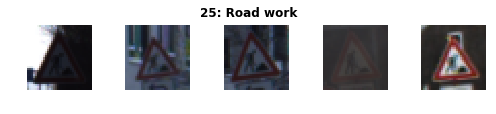

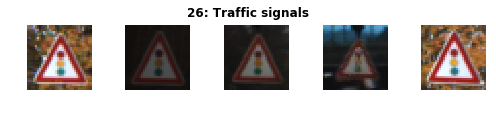

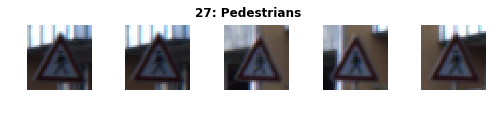

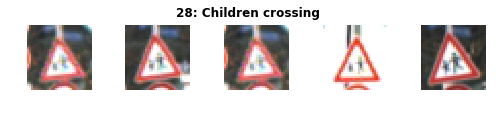

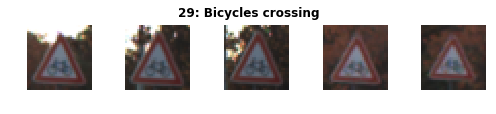

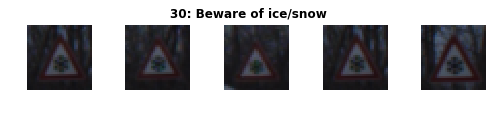

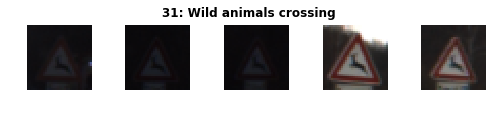

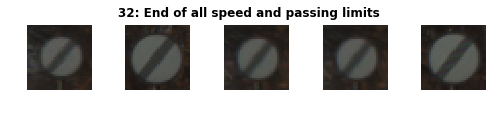

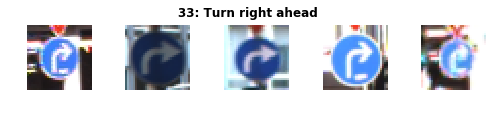

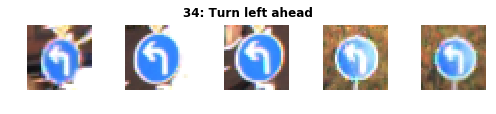

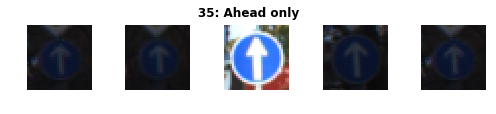

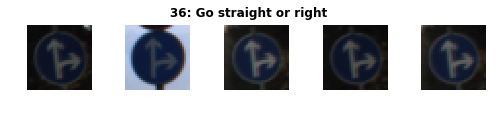

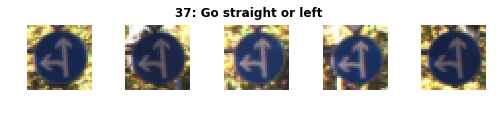

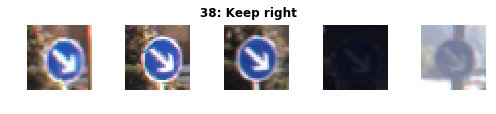

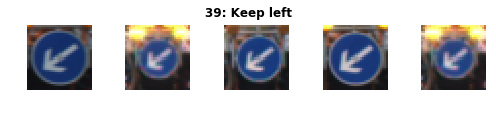

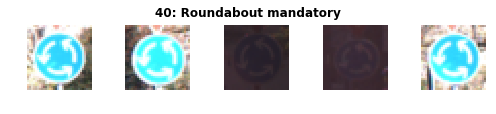

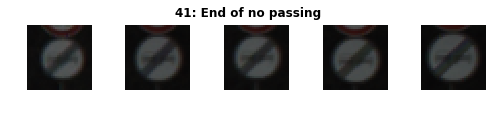

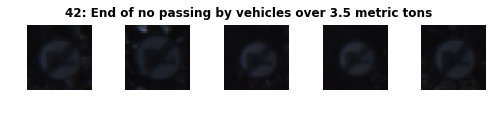

In [17]:
# plot images from each of classes for validation set
X_valid_group_by_label = X_valid_id_to_label.groupby(["label_id", "label_name"])

show_random_dataset_images(X_valid_group_by_label, X_valid)

In [18]:
# create sample set for training data of 33% of training data
X_sample_train, y_sample_train = create_sample_set(X_train_group_by_label, X_train, y_train, pct=0.33)
print("Sample training images dimensions={0}, labels dimensions={1}".format(X_sample_train.shape, y_sample_train.shape))
# create sample set for training data of 33% of validation data
X_sample_valid, y_sample_valid = create_sample_set(X_valid_group_by_label, X_valid, y_valid, pct=0.33)
print("Sample validation images dimensions={0}, labels dimensions={1}".format(X_sample_valid.shape, y_sample_valid.shape))

Sample training images dimensions=(11464, 32, 32, 3), labels dimensions=(11464,)
Sample validation images dimensions=(1427, 32, 32, 3), labels dimensions=(1427,)


In [19]:
# Normalise training, validation and testing datasets
X_train_normalised = normalise_images(X_train, X_train)
X_valid_normalised = normalise_images(X_valid, X_train)
X_test_normalised = normalise_images(X_test, X_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


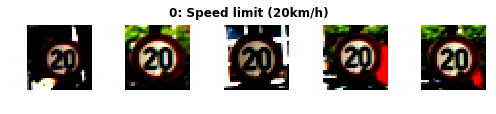

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


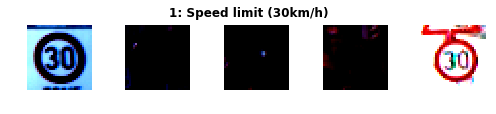

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


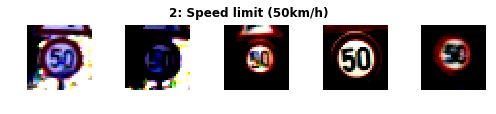

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


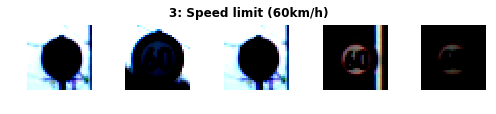

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


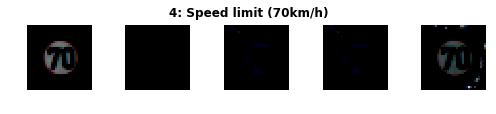

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


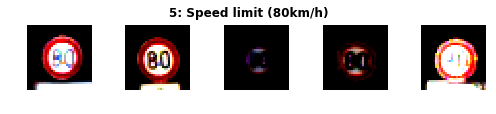

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


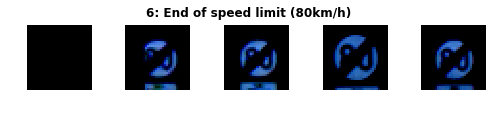

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


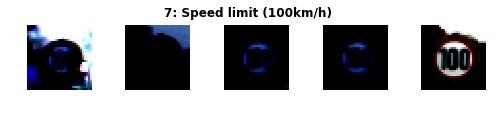

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


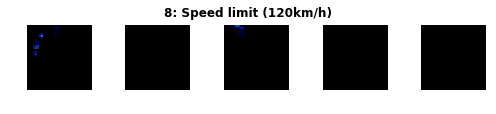

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


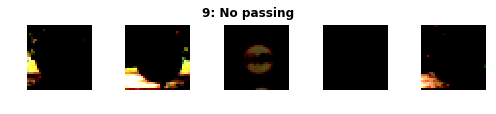

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


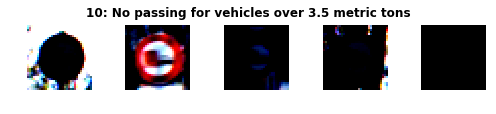

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


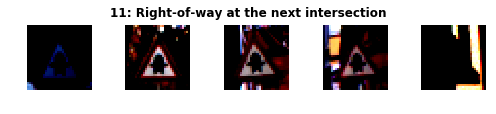

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


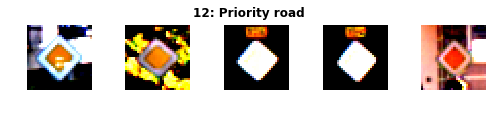

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


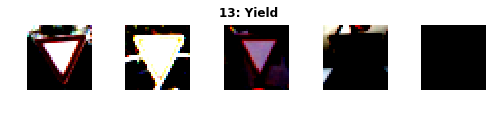

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


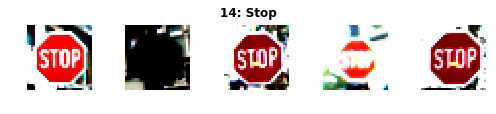

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


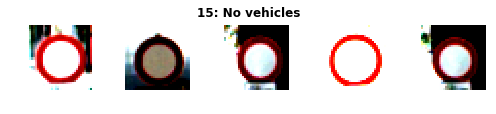

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


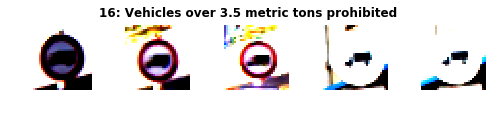

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


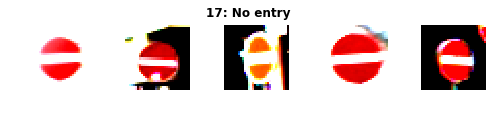

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


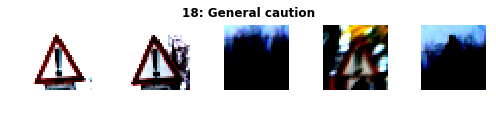

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


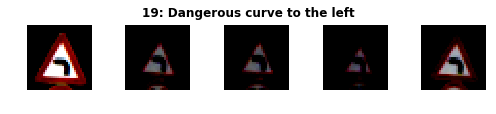

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


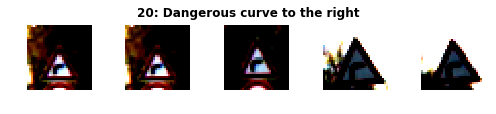

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


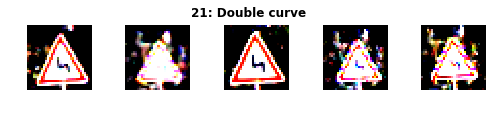

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


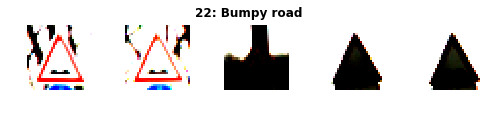

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


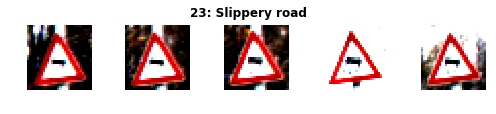

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


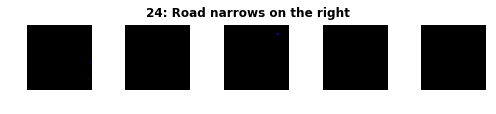

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


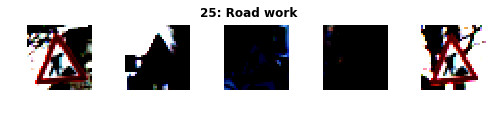

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


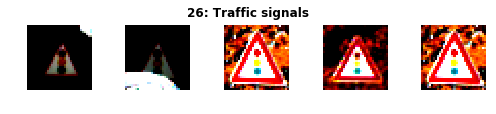

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


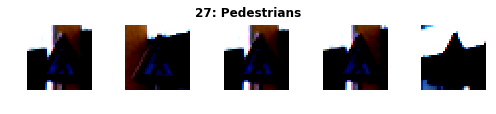

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


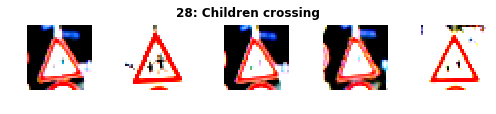

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


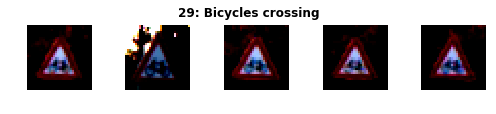

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


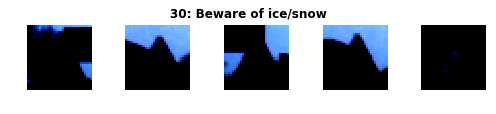

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


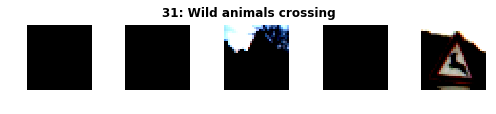

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


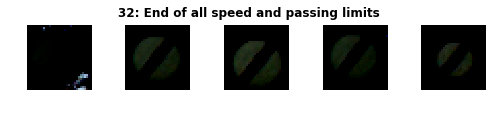

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


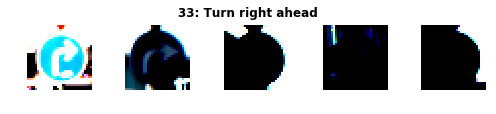

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


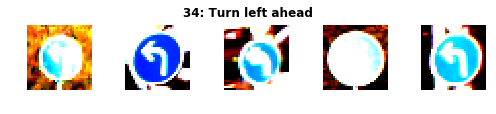

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


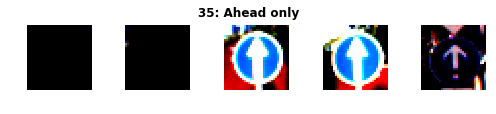

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


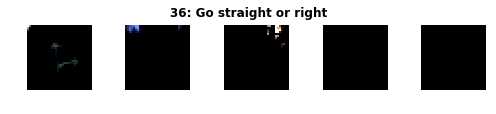

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


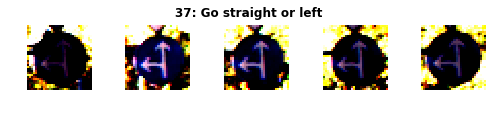

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


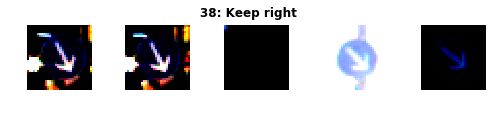

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


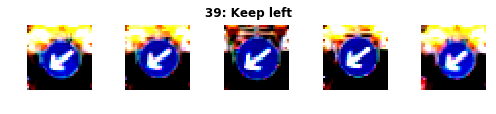

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


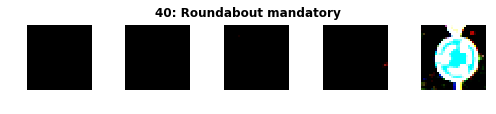

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


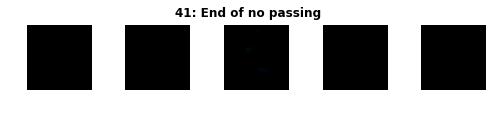

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


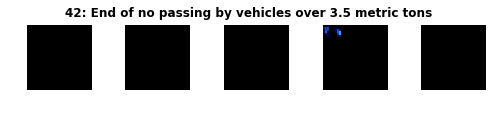

In [20]:
show_random_dataset_images(X_valid_group_by_label, X_valid_normalised)

In [21]:
# convert datasets to grayscale to improve visibility of images
X_train_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_train)))
X_valid_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_valid)))
X_test_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_test)))

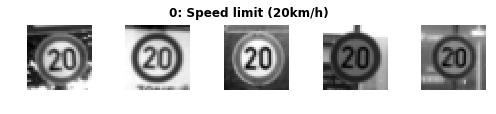

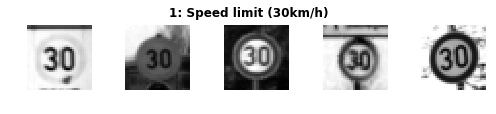

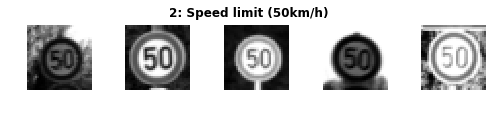

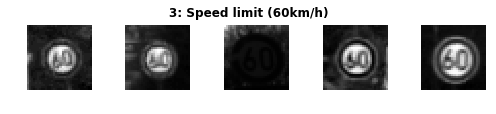

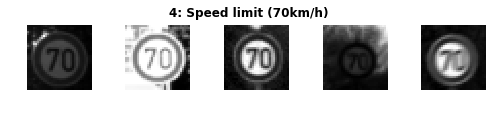

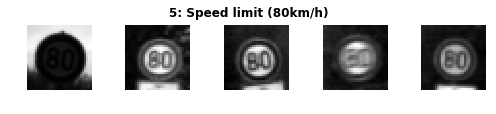

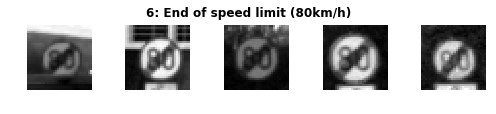

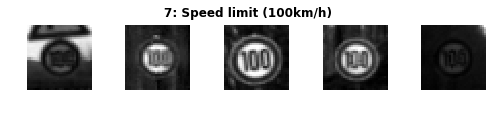

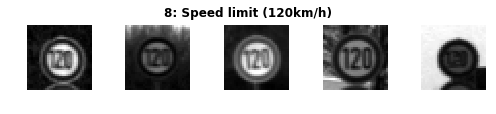

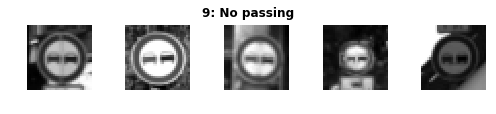

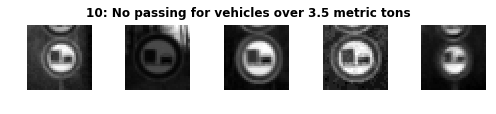

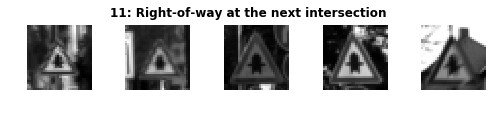

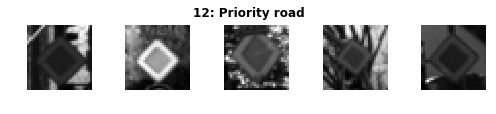

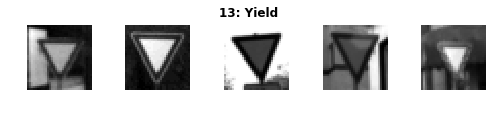

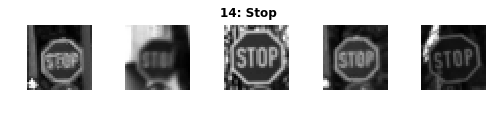

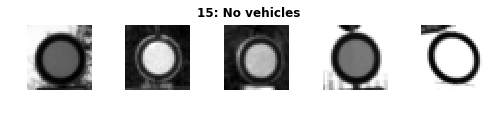

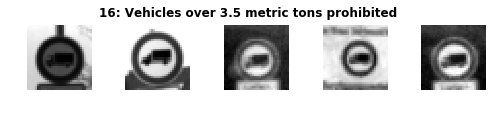

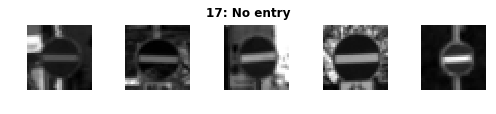

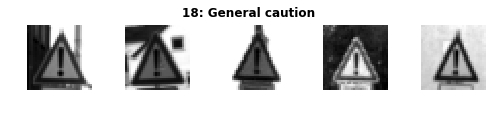

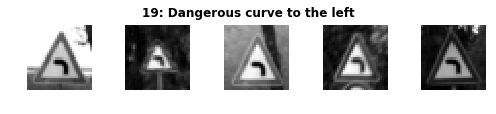

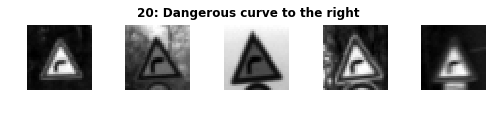

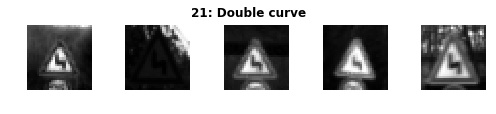

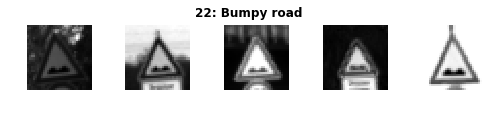

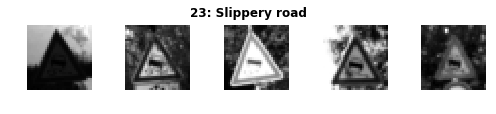

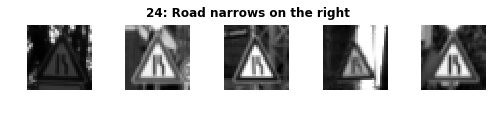

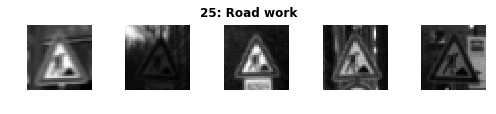

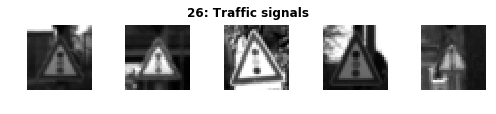

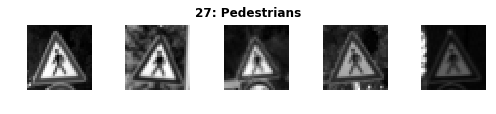

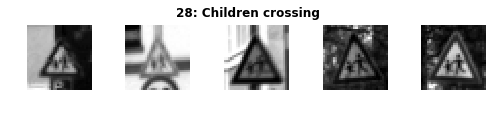

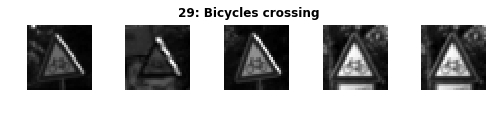

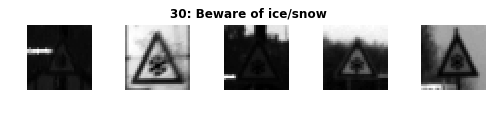

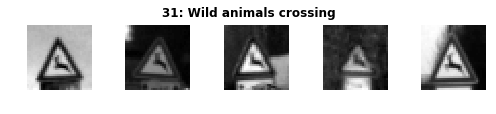

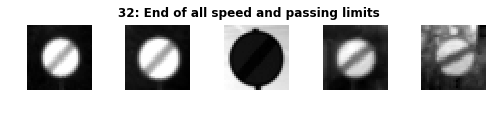

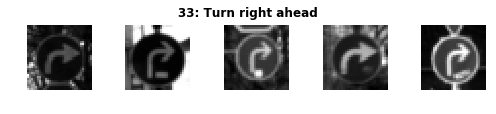

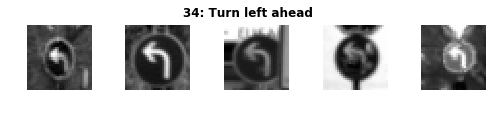

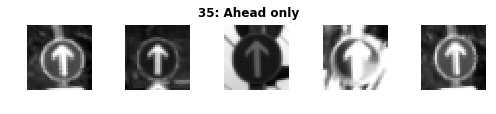

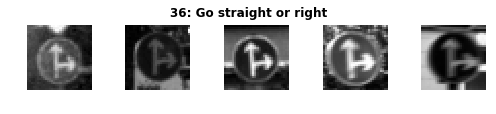

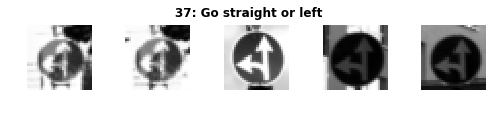

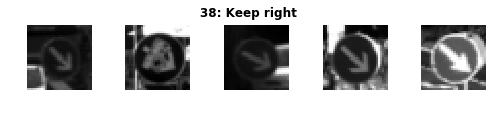

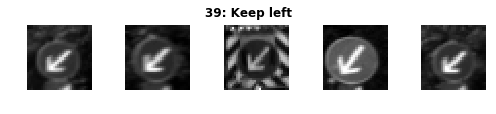

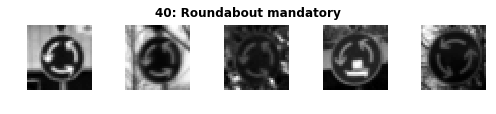

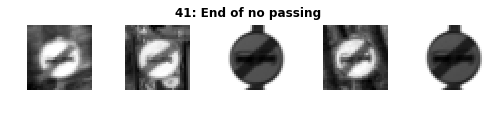

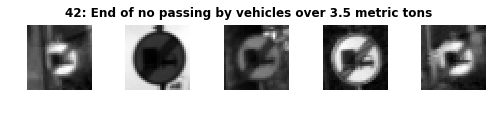

In [22]:
show_random_dataset_images(X_train_group_by_label, X_train_grayscale)

In [23]:
# Model architecture
# config and execution pipeline

In [24]:
class ModelConfig:
    """
    ModelConfig is a utility class that stores important configuration option about our model
    """

    def __init__(self, model, name, input_img_dimensions, conv_layers_config, fc_output_dims, output_classes, dropout_keep_pct):
        self.model = model
        self.name=name
        self.input_img_dimensions = input_img_dimensions
        
        # Determines the wxh dimension of filters, the starting depth (increases by x2 at every layer) 
        # and how many convolutional layers the network has
        self.conv_filter_size = conv_layers_config[0]
        self.conv_depth_start = conv_layers_config[1]
        self.conv_layers_count = conv_layers_config[2]


        self.fc_output_dims = fc_output_dims 
        self.output_classes = output_classes

        # Try with different values for drop out at convolutional and fully connected layers
        self.dropout_conv_keep_pct = dropout_keep_pct[0]
        self.dropout_fc_keep_pct = dropout_keep_pct[1]

In [25]:
class ModelExecutor:
    """
    ModelExecutor is responsible for executing the supplied model
    """
    def __init__(self, model_config, learning_rate=0.001):
        self.model_config = model_config
        self.learning_rate = learning_rate
    
        self.graph = tf.Graph()
        with self.graph.as_default() as g:
            with g.name_scope( self.model_config.name ) as scope:
                # Create Model operations
                self.create_model_operations()

                # Create a saver to persist the results of execution
                self.saver = tf.train.Saver()
    
    def create_placeholders(self):
        """
        Defining our placeholder variables:
            - x, y
            - one_hot_y
            - dropout placeholders
        """

        # e.g. 32 * 32 * 3
        input_dims = self.model_config.input_img_dimensions
        self.x = tf.placeholder(tf.float32, (None, input_dims[0], input_dims[1], input_dims[2]), name="{0}_x".format(self.model_config.name))
        self.y = tf.placeholder(tf.int32, (None), name="{0}_y".format(self.model_config.name))
        self.one_hot_y = tf.one_hot(self.y, self.model_config.output_classes)

        self.dropout_placeholder_conv = tf.placeholder(tf.float32)
        self.dropout_placeholder_fc = tf.placeholder(tf.float32)

    
    def create_model_operations(self):
        """
        Sets up all operations needed to execute run deep learning pipeline
        """

        # First step is to set our x, y, etc
        self.create_placeholders()

        cnn = self.model_config.model

        # Build the network -  TODO: pass the configuration in the future
        self.logits = cnn(self.x, self.model_config, self.dropout_placeholder_conv, self.dropout_placeholder_fc)
        # Obviously, using softmax as the activation function for final layer
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.one_hot_y, logits=self.logits)
        # Combined all the losses across batches
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        # What method do we use to reduce our loss?
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        # What do we really do in a training operation then? Answer: we attempt to reduce the loss using our chosen optimizer
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Get the top prediction for model against labels and check whether they match
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        # Compute accuracy at batch level
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # compute what the prediction would be, when we don't have matching label
        self.prediction = tf.argmax(self.logits, 1)
        # Registering our top 5 predictions
        self.top5_predictions = tf.nn.top_k(tf.nn.softmax(self.logits), k=5, sorted=True, name=None)

        
    def evaluate_model(self, X_data, Y_data, batch_size):
        """
        Evaluates the model's accuracy and loss for the supplied dataset. 
        Naturally, Dropout is ignored in this case (i.e. we set dropout_keep_pct to 1.0)
        """
        
        num_examples = len(X_data)
        total_accuracy = 0.0
        total_loss = 0.0
        sess = tf.get_default_session()

        for offset in range(0, num_examples, batch_size):
            batch_x, batch_y = X_data[offset:offset+batch_size], Y_data[offset:offset+batch_size]
            
            # Compute both accuracy and loss for this batch
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={
                                    self.dropout_placeholder_conv: 1.0,
                                    self.dropout_placeholder_fc: 1.0,
                                    self.x: batch_x, 
                                    self.y: batch_y
                                           })
            loss = sess.run(self.loss_operation, feed_dict={
                                    self.dropout_placeholder_conv: 1.0,
                                    self.dropout_placeholder_fc: 1.0,
                                    self.x: batch_x, 
                                    self.y: batch_y
                                           })

            # Weighting accuracy by the total number of elements in batch
            total_accuracy += (accuracy * len(batch_x))        
            total_loss += (loss * len(batch_x))            

        # To produce a true mean accuracy over whole dataset
        return (total_accuracy / num_examples, total_loss / num_examples) 
    
    
    def train_model(self, X_train_features, X_train_labels, X_valid_features, y_valid_labels, batch_size=512, epochs=100, PRINT_FREQ=10):
        """
        Trains the model for the specified number of epochs supplied when creating the executor
        """

        # Create our array of metrics    
        training_metrics = np.zeros((epochs, 3))
        validation_metrics = np.zeros((epochs, 3))


        with tf.Session(graph = self.graph, config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:            
            
            sess.run(tf.global_variables_initializer())
            num_examples = len(X_train_features)


            print("Training {0} [epochs={1}, batch_size={2}]...\n".format(self.model_config.name, epochs, batch_size))

            for i in range(epochs):
                start = time.time()
                X_train, Y_train = shuffle(X_train_features, X_train_labels)
                for offset in range(0, num_examples, batch_size):
                    end = offset + batch_size
                    batch_x, batch_y = X_train[offset:end], Y_train[offset:end]
                    sess.run(self.training_operation, feed_dict={
                        self.x: batch_x, 
                        self.y: batch_y, 
                        self.dropout_placeholder_conv: self.model_config.dropout_conv_keep_pct,
                        self.dropout_placeholder_fc: self.model_config.dropout_fc_keep_pct,

                    })

                end_training_time = time.time()
                training_duration = end_training_time - start

                #computing training accuracy
                training_accuracy, training_loss = self.evaluate_model(X_train_features, X_train_labels, batch_size)            


                # Computing validation accuracy 
                validation_accuracy, validation_loss = self.evaluate_model(X_valid_features, y_valid_labels, batch_size)


                end_epoch_time = time.time()            
                validation_duration = end_epoch_time - end_training_time   
                epoch_duration = end_epoch_time - start

                if i == 0 or (i+1) % PRINT_FREQ == 0:
                    print("[{0}]\ttotal={1:.3f}s | train: time={2:.3f}s, loss={3:.4f}, acc={4:.4f} | val: time={5:.3f}s, loss={6:.4f}, acc={7:.4f}".format(
                          i+1, epoch_duration, training_duration, training_loss, training_accuracy, 
                        validation_duration, validation_loss, validation_accuracy))

                training_metrics[i] = [training_duration, training_loss, training_accuracy]
                validation_metrics[i] = [validation_duration, validation_loss, validation_accuracy]

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            # Save the model
            self.saver.save(sess, model_file_name)
            print("Model {0} saved".format(model_file_name))

        return (training_metrics, validation_metrics, epoch_duration)
    
    def test_model(self, test_imgs, test_lbs, batch_size=512):
        """
        Evaluates the model with the test dataset and test labels
        Returns the tuple (test_accuracy, test_loss, duration)
        """

        with tf.Session(graph = self.graph) as sess:
            # Never forget to re-initialise the variables
            tf.global_variables_initializer()

            
            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)

            start = time.time()
            (test_accuracy, test_loss) = self.evaluate_model(test_imgs, test_lbs, batch_size)
            duration = time.time() - start
            print("[{0} - Test Set]\ttime={1:.3f}s, loss={2:.4f}, acc={3:.4f}".format(self.model_config.name, duration, test_loss, test_accuracy))

        
        return (test_accuracy, test_loss, duration)
    
    def predict(self, imgs, top_5=False):
        """
        Returns the predictions associated with a bunch of images
        """
        preds = None
        with tf.Session(graph = self.graph) as sess:
            # Never forget to re-initialise the variables
            tf.global_variables_initializer()

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)
            
            if top_5:
                preds = sess.run(self.top5_predictions, feed_dict={
                        self.x: imgs,
                        self.dropout_placeholder_conv: 1.0,
                        self.dropout_placeholder_fc: 1.0
                    })
            else:
                preds = sess.run(self.prediction, feed_dict={
                    self.x: imgs,
                    self.dropout_placeholder_conv: 1.0,
                    self.dropout_placeholder_fc: 1.0
                })
    
        return preds
    
    def show_conv_feature_maps(self, img, conv_layer_idx=0, activation_min=-1, activation_max=-1 ,
                               plt_num=1, fig_size=(15, 15), title_y_pos=1.0):
        """
        Shows the resulting feature maps at a given convolutional level for a SINGLE image
        """
        #s = tf.train.Saver()
        with tf.Session(graph = self.graph) as sess:
            # Never forget to re-initialise the variables
            tf.global_variables_initializer()
            #tf.reset_default_graph()

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)
            
            # Run a prediction
            preds = sess.run(self.prediction, feed_dict={
                    self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                    self.dropout_placeholder_conv: 1.0,
                    self.dropout_placeholder_fc: 1.0
                })

            
            var_name = "{0}/conv_{1}_relu:0".format(self.model_config.name, conv_layer_idx)
            print("Fetching tensor: {0}".format(var_name))
            conv_layer = tf.get_default_graph().get_tensor_by_name(var_name)
            
            activation = sess.run(conv_layer, feed_dict={
                            self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                            self.dropout_placeholder_conv: 1.0,
                            self.dropout_placeholder_fc: 1.0
                            })
            featuremaps = activation.shape[-1]
            # (1, 13, 13, 64)
            print("Shape of activation layer: {0}".format(activation.shape))
            
            #fix the number of columns
            cols = 8
            rows = featuremaps // cols
            fig, axes = plt.subplots(rows, cols, figsize=fig_size)
            k = 0
            for i in range(0, rows):
                for j in range(0, cols):
                    ax = axes[i, j]
                    featuremap = k

                    if activation_min != -1 & activation_max != -1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
                    elif activation_max != -1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
                    elif activation_min !=-1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
                    else:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
                    
                    ax.axis("off")
                    k += 1
            
            fig.suptitle("Feature Maps at layer: {0}".format(conv_layer), fontsize=12, fontweight='bold', y=title_y_pos)
            fig.tight_layout()
            plt.show()


In [26]:
# import tensorflow modules to implement EdLeNet

In [27]:
from tensorflow.contrib.layers import flatten

def EdLeNet(x, mc, dropout_conv_pct, dropout_fc_pct):
    """
    A variant of LeNet created by Yann Le Cun
    The second parameter, which is encapsulates model configuration, enables varying the convolution filter sizes 
    as well as the number of fully connected layers and their output dimensions.
    The third and fourth parameters represent dropout placeholders for convolutional and fully connected layers respectively
    """
    
    # Used for randomly definining weights and biases
    mu = 0
    sigma = 0.1
    
    prev_conv_layer = x
    conv_depth = mc.conv_depth_start
    conv_input_depth = mc.input_img_dimensions[-1]
   
    print("[EdLeNet] Building neural network [conv layers={0}, conv filter size={1}, conv start depth={2}, fc layers={3}]".format(
        mc.conv_layers_count, mc.conv_filter_size, conv_depth, len(mc.fc_output_dims)))
    
    for i in range(0, mc.conv_layers_count):
        # layer depth grows exponentially
        conv_output_depth = conv_depth * (2 ** (i))
        conv_W = tf.Variable(tf.truncated_normal(shape=(mc.conv_filter_size, mc.conv_filter_size, conv_input_depth, conv_output_depth), 
                                              mean = mu, stddev = sigma))
        conv_b = tf.Variable(tf.zeros(conv_output_depth))
        
        conv_output = tf.nn.conv2d(prev_conv_layer, conv_W, strides=[1, 1, 1, 1], padding='VALID', name="conv_{0}".format(i)) + conv_b
        conv_output = tf.nn.relu(conv_output, name="conv_{0}_relu".format(i))
        # Traditional max 2x2 pool 
        conv_output = tf.nn.max_pool(conv_output, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        # Apply dropout - even at the conv level
        conv_output = tf.nn.dropout(conv_output, dropout_conv_pct) 
        
        # Setting our loop variables accordingly
        prev_conv_layer = conv_output
        conv_input_depth = conv_output_depth

    
    # Flatten results of second convolutional layer so that it can be supplied to fully connected layer
    fc0   = flatten(prev_conv_layer)
    
    # Now creating our fully connected layers
    prev_layer = fc0
    for output_dim in mc.fc_output_dims:
        fcn_W  = tf.Variable(tf.truncated_normal(shape=(prev_layer.get_shape().as_list()[-1], output_dim), 
                                                 mean = mu, stddev = sigma))
        fcn_b  = tf.Variable(tf.zeros(output_dim))
        
        prev_layer   = tf.nn.dropout(tf.nn.relu(tf.matmul(prev_layer, fcn_W) + fcn_b), dropout_fc_pct)

    
    # Final layer (Fully Connected)
    fc_final_W  = tf.Variable(tf.truncated_normal(shape=(prev_layer.get_shape().as_list()[-1], mc.output_classes), 
                                                  mean = mu, stddev = sigma))
    fc_final_b  = tf.Variable(tf.zeros(mc.output_classes))
    logits = tf.matmul(prev_layer, fc_final_W) + fc_final_b
    
    return logits


In [28]:
# Training colour sample set

In [29]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_3x3_Color_Sample", [32, 32, 3], [3, 16, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_5x5_Color_Sample", [32, 32, 3], [5, 16, 2], [120, 84], n_classes, [1.0, 1.0])
mc_7x7 = ModelConfig(EdLeNet, "EdLeNet_7x7_Color_Sample", [32, 32, 3], [7, 16, 2], [120, 84], n_classes, [1.0, 1.0])

In [30]:
me_c_sample_3x3 = ModelExecutor(mc_3x3)
me_c_sample_5x5 = ModelExecutor(mc_5x5)
me_c_sample_7x7 = ModelExecutor(mc_7x7)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=16, fc layers=2]
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=16, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=7, conv start depth=16, fc layers=2]


In [31]:
(c_sample_3x3_tr_metrics, c_sample_3x3_val_metrics, c_sample_3x3_duration) = me_c_sample_3x3.train_model(X_sample_train, y_sample_train, X_sample_valid, y_sample_valid, epochs=50)
(c_sample_3x3_ts_accuracy, c_sample_3x3_ts_loss, c_sample_3x3_ts_duration) =  me_c_sample_3x3.test_model(X_test, y_test)

Training EdLeNet_3x3_Color_Sample [epochs=50, batch_size=512]...

[1]	total=11.126s | train: time=6.130s, loss=3.4541, acc=0.1078 | val: time=4.995s, loss=3.5818, acc=0.0876
[10]	total=10.751s | train: time=5.867s, loss=0.4527, acc=0.8794 | val: time=4.884s, loss=1.3685, acc=0.7078
[20]	total=10.461s | train: time=5.572s, loss=0.0620, acc=0.9884 | val: time=4.889s, loss=1.2522, acc=0.7989
[30]	total=12.097s | train: time=6.020s, loss=0.0163, acc=0.9983 | val: time=6.077s, loss=1.3552, acc=0.8157
[40]	total=11.914s | train: time=6.408s, loss=0.0048, acc=1.0000 | val: time=5.506s, loss=1.6313, acc=0.8276
[50]	total=12.339s | train: time=6.933s, loss=0.0024, acc=1.0000 | val: time=5.406s, loss=1.7805, acc=0.8325


ValueError: Parent directory of /Users/eoinmurnaghan/Documents/Stage 4/Stage 4 Project/CarND-Traffic-Sign-Classifier-Project/models/EdLeNet_3x3_Color_Sample.chkpt doesn't exist, can't save.

In [73]:
(c_sample_5x5_tr_metrics, c_sample_5x5_val_metrics, c_sample_5x5_duration) = me_c_sample_5x5.train_model(X_sample_train, y_sample_train, X_sample_valid, y_sample_valid, epochs = 50)

(c_sample_5x5_ts_accuracy, c_sample_5x5_ts_loss, c_sample_5x5_ts_duration) = me_c_sample_5x5.test_model(X_test, y_test)

Training EdLeNet_5x5_Colour_Sample [epochs=50, batch_size=512]...

[1]	total=16.603s | train: time=8.221s, loss=5.2689, acc=0.0887 | val: time=8.383s, loss=5.5047, acc=0.0960
[10]	total=15.810s | train: time=7.846s, loss=0.6760, acc=0.8105 | val: time=7.964s, loss=1.7228, acc=0.5985
[20]	total=16.025s | train: time=8.019s, loss=0.0863, acc=0.9819 | val: time=8.006s, loss=1.6931, acc=0.7344
[30]	total=15.855s | train: time=7.826s, loss=0.0160, acc=0.9986 | val: time=8.029s, loss=1.9525, acc=0.7610
[40]	total=16.809s | train: time=8.532s, loss=0.0250, acc=0.9943 | val: time=8.277s, loss=1.9043, acc=0.7722
[50]	total=15.811s | train: time=7.844s, loss=0.0050, acc=0.9995 | val: time=7.967s, loss=1.9995, acc=0.7947
Model ./models/EdLeNet_5x5_Colour_Sample.chkpt saved
INFO:tensorflow:Restoring parameters from ./models/EdLeNet_5x5_Colour_Sample.chkpt


InvalidArgumentError: Incompatible shapes: [512] vs. [314]
	 [[{{node EdLeNet_5x5_Colour_Sample/Equal}} = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"](EdLeNet_5x5_Colour_Sample/ArgMax, EdLeNet_5x5_Colour_Sample/ArgMax_1)]]

Caused by op 'EdLeNet_5x5_Colour_Sample/Equal', defined at:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-71-8c1554f05c67>", line 2, in <module>
    me_c_sample_5x5 = ModelExecutor(mc_5x5)
  File "<ipython-input-66-cddf9555f523>", line 13, in __init__
    self.create_model_operations()
  File "<ipython-input-66-cddf9555f523>", line 58, in create_model_operations
    self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2734, in equal
    "Equal", x=x, y=y, name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3272, in create_op
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [512] vs. [314]
	 [[{{node EdLeNet_5x5_Colour_Sample/Equal}} = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"](EdLeNet_5x5_Colour_Sample/ArgMax, EdLeNet_5x5_Colour_Sample/ArgMax_1)]]


In [74]:
(c_sample_7x7_tr_metrics, c_sample_7x7_val_metrics, c_sample_7x7_duration) = me_c_sample_7x7.train_model(X_sample_train, y_sample_train, X_sample_valid, y_sample_valid, epochs=50)

(c_sample_7x7_ts_accuracy, c_sample_7x7_ts_loss, c_sample_7x7_ts_duration) =  me_c_sample_7x7.test_model(X_test, y_test)

Training EdLeNet_7x7_Colour_Sample [epochs=50, batch_size=512]...

[1]	total=22.452s | train: time=10.133s, loss=5.5568, acc=0.0550 | val: time=12.319s, loss=5.6671, acc=0.0589
[10]	total=21.864s | train: time=11.022s, loss=1.3117, acc=0.6254 | val: time=10.842s, loss=1.9914, acc=0.5235
[20]	total=19.724s | train: time=9.170s, loss=0.4535, acc=0.8683 | val: time=10.554s, loss=1.6949, acc=0.6896
[30]	total=19.562s | train: time=9.153s, loss=0.1943, acc=0.9450 | val: time=10.409s, loss=1.7906, acc=0.7421
[40]	total=21.008s | train: time=9.637s, loss=0.1067, acc=0.9706 | val: time=11.372s, loss=1.9974, acc=0.7673
[50]	total=19.642s | train: time=9.207s, loss=0.0436, acc=0.9918 | val: time=10.435s, loss=2.2601, acc=0.7835
Model ./models/EdLeNet_7x7_Colour_Sample.chkpt saved
INFO:tensorflow:Restoring parameters from ./models/EdLeNet_7x7_Colour_Sample.chkpt


InvalidArgumentError: Incompatible shapes: [512] vs. [314]
	 [[{{node EdLeNet_7x7_Colour_Sample/Equal}} = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"](EdLeNet_7x7_Colour_Sample/ArgMax, EdLeNet_7x7_Colour_Sample/ArgMax_1)]]

Caused by op 'EdLeNet_7x7_Colour_Sample/Equal', defined at:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-71-8c1554f05c67>", line 3, in <module>
    me_c_sample_7x7 = ModelExecutor(mc_7x7)
  File "<ipython-input-66-cddf9555f523>", line 13, in __init__
    self.create_model_operations()
  File "<ipython-input-66-cddf9555f523>", line 58, in create_model_operations
    self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2734, in equal
    "Equal", x=x, y=y, name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3272, in create_op
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [512] vs. [314]
	 [[{{node EdLeNet_7x7_Colour_Sample/Equal}} = Equal[T=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"](EdLeNet_7x7_Colour_Sample/ArgMax, EdLeNet_7x7_Colour_Sample/ArgMax_1)]]


In [75]:
metrics_arr = [c_sample_7x7_tr_metrics, c_sample_7x7_val_metrics, c_sample_5x5_tr_metrics, c_sample_5x5_val_metrics, c_sample_3x3_tr_metrics, c_sample_3x3_val_metrics]
lbs = ["7x7 training", "7x7 validation", "5x5 training", "7x7 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Color  - Accuracy and Loss of models on sample set"
                    , fig_size=(17, 5))

NameError: name 'c_sample_3x3_val_metrics' is not defined